# 背景与目的

   共享，通过让渡闲置资源的使用权，在有限增加边际成本的前提下，提高了资源利用效率。Airbnb数据集包含结构化的表格数据、非结构化的文本和地图数据。本文基于Airbnb数据集，通过统计分析、时间序列、相关性分析、中英文文本情感分析、数据可视化以及数据应用等多方法对数据集特征进行分析，并探析各特征与价格的关系。数据来源:https://tianchi.aliyun.com/competition/entrance/231715/introduction

# 数据处理

In [103]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas_profiling
import warnings 
import my_functions as my
import datetime
warnings.filterwarnings('ignore')
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
sns.set_style("ticks") # dark/white/darkgrid/whitegrid

## listing表的诊断与清洗

In [37]:
df1=my.reduce_mem_usage(pd.read_csv("listings.csv"))
df2=my.reduce_mem_usage(pd.read_csv("reviews_detail.csv"))

Memory usage of dataframe is 3641984.00 MB
Memory usage after optimization is: 3156184.00 MB
Decreased by 13.3%
Memory usage of dataframe is 9700880.00 MB
Memory usage after optimization is: 14435538.00 MB
Decreased by -48.8%


In [38]:
df1.head() #查看大体上是否不干净的数据

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,NaN,朝阳区 / Chaoyang,39.90625,116.4375,Entire home/apt,792,1,89,2019-03-04,0.850098,9,341
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,NaN,密云县 / Miyun,40.68750,117.1875,Private room,1201,1,2,2017-10-08,0.099976,4,0
2,128496,Heart of Beijing: House with View 2,467520,Cindy,NaN,东城区,39.93750,116.4375,Entire home/apt,389,3,259,2019-02-05,2.699219,1,93
3,161902,cozy studio in center of Beijing,707535,Robert,NaN,东城区,39.93750,116.4375,Entire home/apt,376,1,26,2016-12-03,0.280029,5,290
4,162144,"nice studio near subway, sleep 4",707535,Robert,NaN,朝阳区 / Chaoyang,39.93750,116.4375,Entire home/apt,537,1,37,2018-08-01,0.399902,5,352


name和neighbourhood中英文混合，需要进一步清洗。

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28452 entries, 0 to 28451
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              28452 non-null  int32   
 1   name                            28451 non-null  category
 2   host_id                         28452 non-null  int32   
 3   host_name                       28452 non-null  category
 4   neighbourhood_group             0 non-null      float64 
 5   neighbourhood                   28452 non-null  category
 6   latitude                        28452 non-null  float16 
 7   longitude                       28452 non-null  float16 
 8   room_type                       28452 non-null  category
 9   price                           28452 non-null  int32   
 10  minimum_nights                  28452 non-null  int16   
 11  number_of_reviews               28452 non-null  int16   
 12  last_review       

In [40]:
my.Nullrate(df1)

,0,nullrate,nullrate%
neighbourhood_group,28452,1.000000,100.00
reviews_per_month,11158,0.392169,39.22
last_review,11158,0.392169,39.22
name,1,0.000035,0.00


neighbourhood_group全为缺失值，name有一个缺失值，考虑移除。last_review和reviews_per_month拥有相同比例的缺失值，考虑缺失类型为非完全随机缺失，且缺失量较大，不能简单的删除或者特殊固定值填充，本文将使用可处理缺失值XGB模型对价格进行预测，因此暂不处理这些缺失值。id以及host_id应为分类型数据；last_review应为日期型数据,并继续钻取年、月、周等数据。

In [41]:
df1.drop("neighbourhood_group",axis=1,inplace=True) #移除neighbourhood_group
df1.id=df1.id.astype("category") #数据类型转换
df1.host_id=df1.host_id.astype("category") #数据类型转换
df1.last_review=pd.to_datetime(df1.last_review) #数据类型转换
df1["year"]=df1.last_review.dt.year #日期数据钻取，以便时间序列分析
df1["month"]=df1.last_review.dt.month
df1["weekday"]=df1.last_review.dt.weekday #返回周几


In [42]:
from chinese_calendar import is_workday, is_holiday,is_in_lieu  #判断日期是否工作日；节假日；调休
#由于时间序列数据是德国的日历；因此不能用中国日历来创建特征。
creat_time=pd.to_datetime(df1.last_review, errors='coerce')
df1["is_workday"]=creat_time.apply(lambda x:is_workday(x) )
df1["is_holiday"]=creat_time.apply(lambda x:is_holiday(x) )
df1["is_in_lieu"]=creat_time.apply(lambda x:is_in_lieu(x) )

In [43]:
df1.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,year,month,weekday,is_workday,is_holiday,is_in_lieu
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,朝阳区 / Chaoyang,39.90625,116.4375,Entire home/apt,792,1,...,2019-03-04,0.850098,9,341,2019.0,3.0,0.0,True,False,False
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,密云县 / Miyun,40.68750,117.1875,Private room,1201,1,...,2017-10-08,0.099976,4,0,2017.0,10.0,6.0,False,True,False
2,128496,Heart of Beijing: House with View 2,467520,Cindy,东城区,39.93750,116.4375,Entire home/apt,389,3,...,2019-02-05,2.699219,1,93,2019.0,2.0,1.0,False,True,False
3,161902,cozy studio in center of Beijing,707535,Robert,东城区,39.93750,116.4375,Entire home/apt,376,1,...,2016-12-03,0.280029,5,290,2016.0,12.0,5.0,False,True,False
4,162144,"nice studio near subway, sleep 4",707535,Robert,朝阳区 / Chaoyang,39.93750,116.4375,Entire home/apt,537,1,...,2018-08-01,0.399902,5,352,2018.0,8.0,2.0,True,False,False


### 分类特征

In [44]:
df1.describe(include=["O"]) #查看分类型数据统计结果

,is_workday,is_holiday,is_in_lieu
count,17294,17294,17294
unique,2,2,2
top,False,True,False
freq,8877,8877,16788


id 是房源id，在整个记录中不重复，可作为主键进行索引。id与name数值不一致，说明name中存在重复描述，最大重复值为28，即一个name使用了28次，可能存在异常。
host_id与host_name数值也不一致，说明host_name可能存在多个同名同姓。neighbourhood存在16个非重复字段，类型有点多，且结合上文的head（）结果，neighbourhood需要进一步清洗。

In [45]:
df1.neighbourhood.value_counts()
df1=df1[df1.name.notnull()]

数据格式不统一，中英混合或纯中文，因此可以考虑滤除非汉字部分，统一数据格式。

In [46]:
df1["neighbourhood"]=df1["neighbourhood"].apply(lambda x:re.sub("[A-Za-z0-9/]", "",x)) #滤除非汉字部分
df1["neighbourhood"]=df1["neighbourhood"].apply(lambda x:re.sub("县", "区",x)) #替换
df1["neighbourhood"]=df1["neighbourhood"].apply(lambda x:re.sub(" ", "",x)) #消除空格

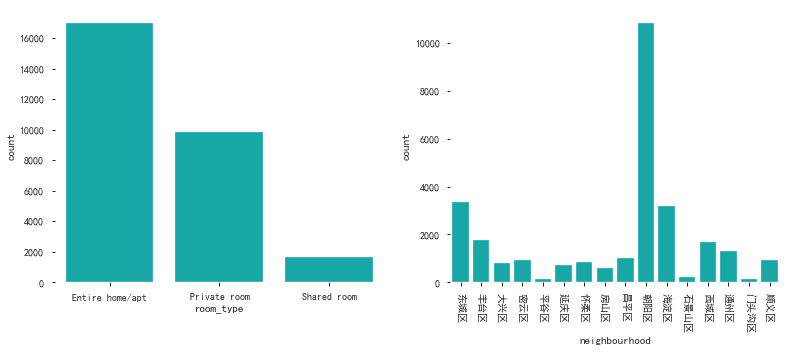

In [47]:
#计数条形图，获取分类数据大致分布情况
category_item=['room_type','neighbourhood']
fig,axes=plt.subplots(1,len(category_item),figsize=(13,5))
plt.subplots_adjust(hspace=1)
plt.xticks(rotation=-90)
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
for i,subset in enumerate(category_item):
    sns.countplot(x=df1[subset],ax=axes[i],color="c")

### 数值特征

In [48]:
df1.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]) #数值型数据统计结果

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,year,month,weekday
count,28451.00000,2.845100e+04,28451.000000,28451.000000,28451.000000,17294.000000,28451.000000,28451.000000,17294.000000,17294.000000,17294.000000
mean,inf,inf,610.873396,2.729746,7.103406,1.320312,12.818706,220.337071,2018.589164,4.840985,3.527640
std,0.18811,2.055664e-01,1622.609504,17.921244,16.815310,1.581055,29.261751,138.430490,0.650965,3.072522,2.163666
min,39.46875,1.155000e+02,0.000000,1.000000,0.000000,0.010002,1.000000,0.000000,2012.000000,1.000000,0.000000
5%,39.81250,1.161875e+02,107.000000,1.000000,0.000000,0.090027,1.000000,0.000000,2017.000000,1.000000,0.000000
25%,39.90625,1.163750e+02,235.000000,1.000000,0.000000,0.290039,2.000000,87.000000,2018.000000,3.000000,2.000000
50%,39.93750,1.164375e+02,389.000000,1.000000,1.000000,0.799805,5.000000,209.000000,2019.000000,4.000000,4.000000
75%,40.00000,1.165000e+02,577.000000,1.000000,6.000000,1.750000,11.000000,361.000000,2019.000000,7.000000,6.000000
95%,40.43750,1.166875e+02,1691.000000,5.000000,35.000000,4.519531,45.000000,365.000000,2019.000000,11.000000,6.000000
max,40.93750,1.175000e+02,68983.000000,1125.000000,322.000000,20.000000,222.000000,365.000000,2019.000000,12.000000,6.000000


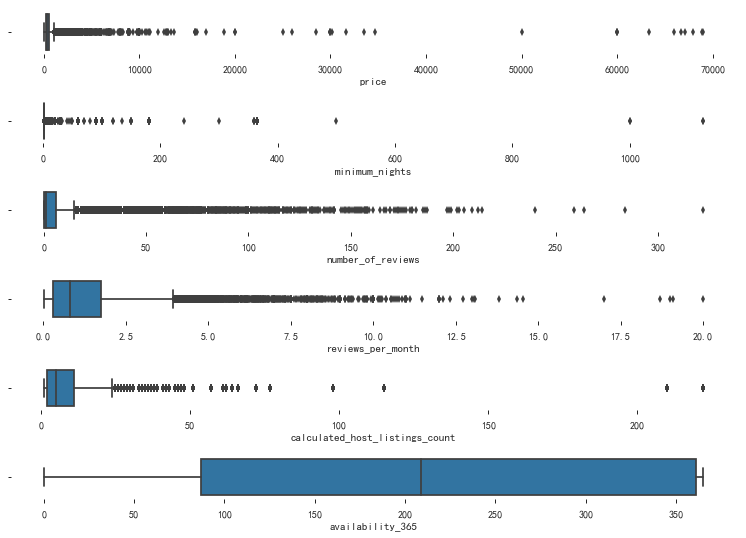

In [49]:
#箱型图，获取数据大致分布情况，查看离群点信息
subsets=['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
fig,axes=plt.subplots(len(subsets),1,figsize=(13,9))
plt.subplots_adjust(hspace=1)
for i,subset in enumerate(subsets):
    sns.boxplot(df1[subset],ax=axes[i],orient='h')

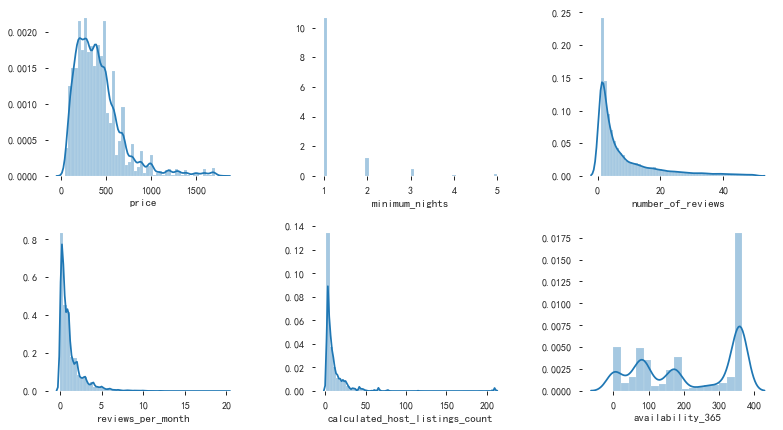

In [50]:
#直方图，获取数据大致分布情况，查看集中信息
fig2,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=plt.subplots(2,3,figsize=(13,7))
axes2=[ax1,ax2,ax3,ax4,ax5,ax6]
plt.subplots_adjust(hspace=.3, wspace=.4)
data=df1[(df1.price<=1778) & (df1.minimum_nights<=5) & (df1.number_of_reviews<=50)]
data=data.dropna(how="any")
for i,subset in enumerate(subsets):
    sns.distplot(data[subset],ax=axes2[i]) 

price为0的记录考虑删除，价格极差很大，标准差系数达到2.65，对于高于10000的记录需要进一步诊断是否异常，价格很高有可能房源是别墅等豪宅。
minimum_nights：95%在5以内，99%在30以内，最大值达到1125，意味着这个房源至少需要连续订阅1125个晚上，与常理不是很吻合,需要进一步诊断。
number_of_reviews:极差很大，99%位数与max差异也很大，需要查看是否存在异常。
availability_365：应在1~365之间，在此区间外的数据应该删除。

In [51]:
df1[df1.price>=10000].head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,year,month,weekday,is_workday,is_holiday,is_in_lieu
1067,12689987,Artistic apartment with culture,68973377,晨斌,朝阳区,39.93750,116.5625,Entire home/apt,67104,1,...,2016-06-03,0.059998,2,365,2016.0,6.0,4.0,True,False,False
1227,13418237,Great Wall Paradise Villa,6628610,Chris,怀柔区,40.46875,116.6250,Entire home/apt,10066,1,...,2019-04-06,0.189941,1,364,2019.0,4.0,5.0,False,True,False
2012,15488817,Hotel apartment close to huge Mall,68973377,晨斌,朝阳区,39.90625,116.5625,Entire home/apt,63346,1,...,2017-04-17,0.549805,2,180,2017.0,4.0,0.0,True,False,False
3427,18554424,东五环北欧风小两居,46923669,Shirley,朝阳区,39.84375,116.5625,Entire home/apt,10998,1,...,NaT,NaN,2,364,NaN,NaN,NaN,NaN,NaN,NaN
4199,19643684,观城9号(整院儿 圣泉寺 慕田峪 箭扣长城 红螺寺 响水湖),47672470,经纬,顺义区,40.18750,116.8750,Entire home/apt,33471,1,...,NaT,NaN,6,360,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df1[df1.price>=10000].room_type.value_counts()

Entire home/apt    33
Private room       11
Shared room         4
Name: room_type, dtype: int64

在超过10000的高价房源中，有4个房源为合租类型，与现实场景不太吻合，因此考虑将此记录移除。同时，对高价房源中房屋类型为单租且缺失值较多的记录也予以删除。

In [53]:
df1[df1.minimum_nights>=365].head(10)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,year,month,weekday,is_workday,is_holiday,is_in_lieu
1175,13183350,鸟巢旁欧式罗曼蒂克两居,56183837,Jack,朝阳区,40.00000,116.3750,Entire home/apt,463,1000,...,2016-07-25,0.059998,1,0,2016.0,7.0,0.0,True,False,False
2192,15948304,"离车公庄地铁5分钟,离新街口步行十分钟｡交通便利｡环境幽雅,安全｡",78186433,Bo,西城区,39.93750,116.3750,Entire home/apt,376,365,...,NaT,NaN,1,364,NaN,NaN,NaN,NaN,NaN,NaN
3227,18258080,海淀魏公村万寿寺甲3号 3室1厅 160平米(只接受个人年长租),122796150,Xu,海淀区,39.93750,116.3125,Entire home/apt,550,365,...,NaT,NaN,1,365,NaN,NaN,NaN,NaN,NaN,NaN
3313,18402988,Beijing Sunshine place,96817654,宁Ning,东城区,39.90625,116.4375,Entire home/apt,396,365,...,2018-09-30,1.179688,1,364,2018.0,9.0,6.0,True,False,False
4773,20311554,"京都爱巢,为您准备",144803735,福春,海淀区,39.96875,116.3125,Entire home/apt,490,365,...,2017-08-20,0.099976,2,90,2017.0,8.0,6.0,False,True,False
4836,20417131,"护城河边,观望京都",144803735,福春,海淀区,39.90625,116.3125,Entire home/apt,591,365,...,NaT,NaN,2,365,NaN,NaN,NaN,NaN,NaN,NaN
4981,20589657,爱屋吉屋,130855713,茜,朝阳区,39.84375,116.5625,Entire home/apt,302,365,...,NaT,NaN,1,362,NaN,NaN,NaN,NaN,NaN,NaN
5609,21098578,6号14号线金台路青旅燕儿窝上下铺国贸CBD,129486966,磊,朝阳区,39.90625,116.5000,Shared room,121,1124,...,2018-08-03,0.330078,6,362,2018.0,8.0,4.0,True,False,False
5857,21319861,嵩山居·首都机场店,154311879,涛,昌平区,40.09375,116.4375,Private room,268,365,...,NaT,NaN,1,364,NaN,NaN,NaN,NaN,NaN,NaN
6505,21841908,鸟巢水立方朝南大主卧,159278266,小梦,海淀区,40.03125,116.3750,Private room,255,1000,...,NaT,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN


分析：有些房源以年来长租，因此可能存在minimum_nights大于365的情况，不是异常，例如：id位18258080的房源。但如果房子年租（minimum_nights>365），且price超过95%分位数则可能是异常数据，考虑移除。

In [54]:
df1=df1[~((df1.price>10000)&(df1.room_type.isin(["Private room","Shared room"]))&(df1.last_review.isnull()))]
df1=df1[~((df1.minimum_nights>365)&(df1.price>df1.price.quantile(q=0.95)))]
df1=df1[df1["price"]>0]
df1=df1[(0<df1["availability_365"]) & (df1["availability_365"]<=365) ]

## review表的诊断与清洗

In [55]:
df2.head(3).append(df2.tail(3))

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...
202096,33891613,438182693,2019-04-16,255994654,天佑,"房间布置明亮温暖而别有风格,指引周到而迅速,房间内设施齐全､空间宽敞!"
202097,33892088,438119657,2019-04-16,255993753,志强,"各方面这个价位性价比是非常之高了,房东人也很好,交通便利,我个人是很满意的,有机会还会来｡"
202098,33925874,438572523,2019-04-17,256375057,玲,The host canceled this reservation 13 days bef...


In [56]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202099 entries, 0 to 202098
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   listing_id     202099 non-null  int32   
 1   id             202099 non-null  int32   
 2   date           202099 non-null  category
 3   reviewer_id    202099 non-null  int32   
 4   reviewer_name  202093 non-null  category
 5   comments       201983 non-null  category
dtypes: category(3), int32(3)
memory usage: 13.8 MB


data_review异常诊断：
reviewer_name和comments 存在一定程度缺失，由于确实比例不是很大，考虑直接移除缺失记录。
date应为日期格式；id、listing_id、reviewer_id应为类别型数据；reviewer_name中英混合，可以想办法进行整合。
comments中英混合，考虑进行拆分，进而做中英文文本情感分析。

In [57]:
df2=df2.dropna(axis=0) #移除有缺失值的行
df2.id=df2.id.astype('object')
df2.reviewer_id=df2.reviewer_id.astype("object")
df2.listing_id=df2.listing_id.astype("object")
df2.date=pd.to_datetime(df2.date)
df2["Chinese_comments"]=df2.comments.apply(lambda x:re.sub("[A-Za-z0-9\!\%\?()./[\]\- 	:;,\。 ' ...r'\n\r\n\r\n'""	 	]", "",str(x))) #滤除非汉字部分
df2["Chinese_comments"]=df2["Chinese_comments"].apply(lambda x : re.sub("","无",x))
df2["English_comments"]=df2.comments.apply(lambda x:re.sub("[\u4e00-\u9fa5...r'\n\r\n\r\n'!""	]", "",str(x))) #滤除汉字部分

#### NLP情感倾向统计

In [58]:
from textblob import TextBlob #英文文本情感分析库
def CalPolarity(text):
    blob=TextBlob(text)
    return blob.sentiment.polarity #输出该文本的情感极数（-1~1）

In [59]:
# df2["Polarity"]=df2.English_comments.apply(lambda x: CalPolarity(x) )

In [60]:
from snownlp import SnowNLP #中文文本情感分析库
def CalProbability(text): 
    s = SnowNLP(text)
    return s.sentiments #输出该文本为正面评价的概率

In [61]:
# df2.Chinese_comments=df2.Chinese_comments.apply(lambda x: re.sub(r"", "无", str(x))) 

In [62]:
# df2["ProbaPositive"]=df2.Chinese_comments.apply(lambda x: CalProbability(x) ) #运行时间太长；将线下运行的结果import进来

In [413]:
df2=pd.read_csv("df2new_pro.csv")

In [414]:
newdf2=df2.groupby("listing_id")["Polarity","ProbaPositive"].mean()

In [415]:
newdf2.head()

,Polarity,ProbaPositive
listing_id,,
44054,0.205774,0.511484
100213,0.202778,0.557248
128496,0.368798,0.424662
161902,0.269895,0.415101
162144,0.204663,0.491734


In [528]:
newdf=pd.merge(df1,newdf2,how="left",left_on="id",right_on="listing_id")

In [529]:
def count_feat(df,cols): #统计自身的各值频数
    for col in cols:
        newF1 = df.groupby([col])[col].count().to_frame().rename(columns={col:col+'__count'})
        df = pd.merge(df, newF1, on=[col], how='left')
    return df

In [530]:
newdf[["ProbaPositive",'Polarity']].describe()

,ProbaPositive,Polarity
count,15800.000000,15800.000000
mean,0.782865,0.030013
std,0.207672,0.075553
min,0.000000,-0.533333
25%,0.703401,0.000000
50%,0.826099,0.000000
75%,0.941616,0.027852
max,1.000000,1.000000


In [418]:
newdf=count_feat(newdf,["room_type","neighbourhood","host_id"])

In [419]:
newdf["today"]=datetime.date.today()

In [420]:
newdf["last_rewtonow"]=pd.to_datetime(newdf["today"])-pd.to_datetime(df1.last_review, errors='coerce')

In [421]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25815 entries, 0 to 25814
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   id                              25815 non-null  int64          
 1   name                            25815 non-null  category       
 2   host_id                         25815 non-null  category       
 3   host_name                       25815 non-null  category       
 4   neighbourhood                   25815 non-null  category       
 5   latitude                        25815 non-null  float16        
 6   longitude                       25815 non-null  float16        
 7   room_type                       25815 non-null  category       
 8   price                           25815 non-null  int32          
 9   minimum_nights                  25815 non-null  int16          
 10  number_of_reviews               25815 non-null  int16     

In [422]:
newdf[["last_review","year","month","weekday","is_workday","is_holiday","is_in_lieu"]].head()

,last_review,year,month,weekday,is_workday,is_holiday,is_in_lieu
0,2019-03-04,2019.0,3.0,0.0,True,False,False
1,2019-02-05,2019.0,2.0,1.0,False,True,False
2,2016-12-03,2016.0,12.0,5.0,False,True,False
3,2018-08-01,2018.0,8.0,2.0,True,False,False
4,2018-11-02,2018.0,11.0,4.0,True,False,False


In [423]:
newdf.to_csv("data_all",index=None)

# 多维度数据分析

In [424]:
num_feat=['price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'Polarity',
 'ProbaPositive',
 'room_type__count',
 'neighbourhood__count',
 'host_id__count',
 'last_rewtonow']

* 数值标准化

In [425]:
#对参与计算的数值进行标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
for i in num_feat:
    newdf[i] = ss.fit_transform(newdf[i].values.reshape(-1,1))

In [426]:
newdf.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,is_workday,is_holiday,is_in_lieu,Polarity,ProbaPositive,room_type__count,neighbourhood__count,host_id__count,today,last_rewtonow
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,朝阳区,39.90625,116.4375,Entire home/apt,0.132517,-0.107866,...,True,False,False,2.326400,-1.306818,0.743393,1.269714,-0.141694,2020-05-15,0.827420
1,128496,Heart of Beijing: House with View 2,467520,Cindy,东城区,39.93750,116.4375,Entire home/apt,-0.158064,0.034476,...,False,True,False,4.484224,-1.724907,0.743393,-0.422563,-0.445191,2020-05-15,-1.206644
2,161902,cozy studio in center of Beijing,707535,Robert,东城区,39.93750,116.4375,Entire home/apt,-0.167438,-0.107866,...,False,True,False,3.175118,-1.770944,0.743393,-0.422563,-0.293442,2020-05-15,0.827932
3,162144,"nice studio near subway, sleep 4",707535,Robert,朝阳区,39.93750,116.4375,Entire home/apt,-0.051350,-0.107866,...,True,False,False,2.311697,-1.401925,0.743393,1.269714,-0.293442,2020-05-15,0.843000
4,279078,Nice Apartment in Beijing,1455726,Fiona,东城区,39.93750,116.4375,Entire home/apt,-0.147970,-0.107866,...,True,False,False,1.757127,-1.285243,0.743393,-0.422563,-0.217568,2020-05-15,0.831500


* 指标建立

In [427]:
#便捷度:minimum_nights+availability_365 +neighbourhood__count+room_type__count
newdf["convenience"]=0.35*(1-newdf.minimum_nights)+0.2*newdf.availability_365 +0.25*newdf.neighbourhood__count+0.2*newdf.room_type__count

In [428]:
#热度：neighbourhood__count+number_of_reviews+reviews_per_month+last_rewtonow
newdf["hotness"]=0.15*newdf.neighbourhood__count+0.4*newdf.number_of_reviews+0.3*newdf.reviews_per_month+0.15*newdf.last_rewtonow

In [429]:
#好评率：Polarity+ProbaPositive
newdf["reputation"]=0.4*newdf.Polarity+0.6*newdf.ProbaPositive

In [430]:
#体验：便捷度+好评率
newdf["experience"]=0.3*newdf["convenience"]+0.7*newdf["reputation"]

In [431]:
#性价比：体验/价格
newdf["cost_performance"]=newdf["experience"]/newdf.price

In [432]:
#推荐度：体验+性价比+热度
newdf["recommendation"]=0.3*newdf["experience"]+0.5*newdf["cost_performance"]+0.2*newdf["hotness"]

In [433]:
#房东质量分数：房源量+房源推荐度
newdf["host_quanlity"]=0.6*newdf.host_id__count+0.4*newdf.recommendation

In [434]:
newdf

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,host_id__count,today,last_rewtonow,convenience,hotness,reputation,experience,cost_performance,recommendation,host_quanlity
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,朝阳区,39.90625,116.4375,Entire home/apt,0.132517,-0.107866,...,-0.141694,2020-05-15,0.827420,1.010856,2.113001,0.146469,0.405785,3.062132,2.075402,0.745144
1,128496,Heart of Beijing: House with View 2,467520,Cindy,东城区,39.93750,116.4375,Entire home/apt,-0.158064,0.034476,...,-0.445191,2020-05-15,-1.206644,0.141861,5.847522,0.758745,0.573680,-3.629407,-0.473095,-0.456353
2,161902,cozy studio in center of Beijing,707535,Robert,东城区,39.93750,116.4375,Entire home/apt,-0.167438,-0.107866,...,-0.293442,2020-05-15,0.827932,0.506329,0.289447,0.207481,0.297135,-1.774598,-0.740269,-0.472173
3,162144,"nice studio near subway, sleep 4",707535,Robert,朝阳区,39.93750,116.4375,Entire home/apt,-0.051350,-0.107866,...,-0.293442,2020-05-15,0.843000,1.028425,0.823387,0.083524,0.366994,-7.146972,-3.298710,-1.495550
4,279078,Nice Apartment in Beijing,1455726,Fiona,东城区,39.93750,116.4375,Entire home/apt,-0.147970,-0.107866,...,-0.217568,2020-05-15,0.831500,0.606953,0.369097,-0.068295,0.134279,-0.907477,-0.339635,-0.266395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25810,33948728,"望京西门子,798,央美附近 温馨如家大床民宿",256112655,旭,朝阳区,40.00000,116.5000,Entire home/apt,-0.153017,-0.107866,...,-0.445191,2020-05-15,-1.206644,0.608361,NaN,NaN,NaN,NaN,NaN,NaN
25811,33948787,04简约舒适电梯房/工体/三里屯/东大桥/朝阳医院/世贸天阶/国贸,147335664,Pony,朝阳区,39.93750,116.4375,Entire home/apt,0.500251,0.034476,...,-0.255505,2020-05-15,0.826680,0.422779,NaN,NaN,NaN,NaN,NaN,NaN
25812,33950006,临近地铁温馨网红风小屋一居室,141786513,昊,朝阳区,39.90625,116.5000,Entire home/apt,-0.201327,-0.107866,...,-0.445191,2020-05-15,-1.206644,1.045994,NaN,NaN,NaN,NaN,NaN,NaN
25813,33950535,"3. 老国展,三元桥地铁,静安东里大床房",213500128,晓征,朝阳区,39.96875,116.4375,Private room,-0.302995,-0.107866,...,-0.255505,2020-05-15,-1.206644,0.266781,NaN,NaN,NaN,NaN,NaN,NaN


In [435]:
newdf.to_csv("newdf_indicator.csv",index=None)

## 房源分析

### 房源位置

In [436]:
indicator= ['convenience',
 'hotness',
 'reputation',
 'experience',
 'cost_performance',
 'recommendation']

In [437]:
neighbourhood_gr=newdf.groupby("neighbourhood")[indicator].mean().sort_values(by='recommendation',ascending=False)

In [438]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
for i in indicator:
    neighbourhood_gr[i]=mms.fit_transform(neighbourhood_gr[i].values.reshape(-1,1))

In [439]:
neighbourhood_gr.head()

,convenience,hotness,reputation,experience,cost_performance,recommendation
neighbourhood,,,,,,
门头沟区,0.198562,0.000000,0.000000,0.000000,1.000000,1.000000
延庆区,0.000000,0.032649,0.282043,0.122346,0.980912,0.986470
大兴区,0.165247,0.272973,0.569432,0.292341,0.900407,0.925912
怀柔区,0.099760,0.147957,0.975847,0.476218,0.837558,0.858707
西城区,0.109862,0.678617,0.784498,0.315350,0.796267,0.848090


In [516]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.faker import Faker

c = (
    Map()
    .add("neighbourhood", [list(z) for z in zip(neighbourhood_gr.index, neighbourhood_gr.experience)], "北京")
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Map-北京地图"), visualmap_opts=opts.VisualMapOpts(max_=1, is_piecewise=True)
    )

)
c.load_javascript()

In [517]:
c.render_notebook()

In [514]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Radar
v1 = [neighbourhood_gr.iloc[0,:].values.tolist()]
v2 = [neighbourhood_gr.iloc[1,:].values.tolist()]
v3 = [neighbourhood_gr.iloc[2,:].values.tolist()]

c = (
    Radar()
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name="convenience", max_=neighbourhood_gr.convenience.max()),
            opts.RadarIndicatorItem(name="hotness", max_=neighbourhood_gr.hotness.max()),
            opts.RadarIndicatorItem(name="reputation", max_=neighbourhood_gr.reputation.max()),
            opts.RadarIndicatorItem(name="experience", max_=neighbourhood_gr.experience.max()),
            opts.RadarIndicatorItem(name="cost_performance", max_=neighbourhood_gr.cost_performance.max()),
            opts.RadarIndicatorItem(name="recommendation", max_=neighbourhood_gr.recommendation.max()),
        ]
    )
    .add("门头沟区", v1)
    .add("延庆区", v2)
    .add("大兴区", v3)
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        legend_opts=opts.LegendOpts(selected_mode="single"),
        title_opts=opts.TitleOpts(title="Radar-单例模式"),
    )

)
c.load_javascript()


In [515]:
c.render_notebook()

### 房屋类型

In [472]:
roomtype_gr=newdf.groupby("room_type")[indicator].mean().sort_values(by='recommendation',ascending=False)

In [476]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
for i in indicator:
    roomtype_gr[i]=mms.fit_transform(roomtype_gr[i].values.reshape(-1,1))

In [477]:
roomtype_gr.head()

,convenience,hotness,reputation,experience,cost_performance,recommendation
room_type,,,,,,
Shared room,0.000000,0.000000,0.281613,0.000000,1.000000,1.000000
Private room,0.374969,1.000000,1.000000,0.751628,0.827321,0.900815
Entire home/apt,1.000000,0.014985,0.000000,1.000000,0.000000,0.000000


In [480]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Radar
v1 = [roomtype_gr.iloc[0,:].values.tolist()]
v2 = [roomtype_gr.iloc[1,:].values.tolist()]
v3 = [roomtype_gr.iloc[2,:].values.tolist()]

c = (
    Radar()
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name="convenience", max_=roomtype_gr.convenience.max()),
            opts.RadarIndicatorItem(name="hotness", max_=roomtype_gr.hotness.max()),
            opts.RadarIndicatorItem(name="reputation", max_=roomtype_gr.reputation.max()),
            opts.RadarIndicatorItem(name="experience", max_=roomtype_gr.experience.max()),
            opts.RadarIndicatorItem(name="cost_performance", max_=roomtype_gr.cost_performance.max()),
            opts.RadarIndicatorItem(name="recommendation", max_=roomtype_gr.recommendation.max()),
        ]
    )
    .add("host_quanlity1", v1)
    .add("host_quanlity2", v2)
    .add("host_quanlity3", v3)
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        legend_opts=opts.LegendOpts(selected_mode="single"),
        title_opts=opts.TitleOpts(title="Radar-单例模式"),
    )

)
c.load_javascript()


In [481]:
c.render_notebook()

### 交叉分析

In [443]:
pd.pivot_table(newdf,index=["neighbourhood"],values=["price"]+indicator,columns=["room_type"],aggfunc=[np.mean],fill_value=0,margins=False)

mean                                            \
                  convenience                          cost_performance   
room_type     Entire home/apt Private room Shared room  Entire home/apt   
neighbourhood                                                             
东城区                  0.354251     0.003144   -0.201467        -0.921186   
丰台区                  0.346734    -0.050243   -0.308848        -0.690218   
大兴区                  0.283706    -0.026294   -0.343567         0.049373   
密云区                  0.260666    -0.018827   -0.181909        -0.823313   
平谷区                  0.241275    -0.133032   -0.517964        -0.940230   
延庆区                  0.265884    -0.114509   -0.553766        -0.775649   
怀柔区                  0.305253    -0.024302   -0.267962         0.234437   
房山区                  0.262572    -0.060431   -0.463172        -0.137546   
昌平区                  0.303419    -0.114991   -0.444453         0.044251   
朝阳区                  0.804830     0.441733    0.155820        -2.196557   
海淀区                  0.406193     0.027167   -0.287363        -0.445394   
石景山区                 0.302248    -0.134725   -0.579780        -5.396555   
西城区                  0.277923    -0.041562   -0.386467        -0.603560   
通州区                  0.372073    -0.045465   -0.356872        -0.283448   
门头沟区                 0.273138    -0.032508   -0.596906         1.096694   
顺义区                  0.247353    -0.038379   -0.317277         0.133346   

                                                                     \
                                            experience                
room_type     Private room Shared room Entire home/apt Private room   
neighbourhood                                                         
东城区              -0.918392    0.126035        0.121170     0.081610   
丰台区              -0.108831    0.565380        0.042360     0.026486   
大兴区               1.780716    0.692357        0.059387     0.008959   
密云区               0.401355    0.000000        0.049940    -0.103640   
平谷区               0.725149    0.421993        0.050803    -0.086212   
延庆区               4.448827    0.000000        0.057918    -0.127143   
怀柔区               0.277515   -0.951910        0.124899     0.032066   
房山区              -0.027444    0.805121        0.111957    -0.015451   
昌平区              -0.742922    0.727920        0.038776     0.048362   
朝阳区              -0.616735   -0.150824        0.230880     0.192742   
海淀区               0.150475   -0.091612        0.083526     0.033811   
石景山区             -0.531924    3.780152        0.098090    -0.167021   
西城区               1.381999    0.227727        0.079525    -0.011675   
通州区               0.346541    0.174208        0.012814     0.022975   
门头沟区              0.638291    1.069473       -0.027026     0.030863   
顺义区              -1.779667    0.566182        0.014032     0.018876   

                                           ...                              \
                                  hotness  ...                       price   
room_type     Shared room Entire home/apt  ... Shared room Entire home/apt   
neighbourhood                              ...                               
东城区             -0.046487        0.266443  ...    0.219825        0.111495   
丰台区             -0.219920       -0.117389  ...   -0.198761       -0.106406   
大兴区             -0.231963       -0.229180  ...   -0.366074       -0.045375   
密云区              0.000000       -0.224834  ...    0.000000        0.428038   
平谷区             -0.160419       -0.332911  ...   -0.365174        0.618708   
延庆区              0.000000       -0.414252  ...    0.000000        0.807420   
怀柔区             -0.923021       -0.313859  ...   -0.550079        1.124750   
房山区             -0.221826       -0.204081  ...   -0.459020        0.138097   
昌平区             -0.258091       -0.306714  ...   -0.362679        0.790067   
朝阳区              0.037654        0.354803  ...    0.245314        0.009955   
海淀区        

## 房东分析

房东分析：量化房东旗下房源数量，房源位置，房源价格，可租天数、房源评价等信息，为房东计算质量分数。有了这个质量分数，airbnb能够有针对性的维护高质量房东，为他们提供佣金折扣以及各种福利待遇；也能够惩罚低质量房东，督促房东改进房源，提升平台的整理质量。

In [444]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
newdf["host_id"]=le.fit_transform(newdf["host_id"])

In [445]:
host=newdf.groupby("host_id")[indicator+["host_quanlity"]].mean().sort_values(by='host_quanlity',ascending=False)

In [446]:
host.head()

,convenience,hotness,reputation,experience,cost_performance,recommendation,host_quanlity
host_id,,,,,,,
5163,-0.101211,-0.694468,-2.420811,-1.724931,213.301148,105.994201,42.153328
3534,0.970926,3.236059,0.138198,0.388016,193.253340,97.390287,38.689000
4905,0.509570,-0.383209,-2.420811,-1.541697,190.642805,94.782252,37.645786
4781,0.719389,-0.209311,-2.420800,-1.382199,170.919739,85.003347,33.779749
6271,0.792039,-0.061905,-1.901546,-1.169657,144.637169,71.955307,28.537770


In [447]:
from sklearn.preprocessing import MinMaxScaler
ls=host.columns.tolist()
mms = MinMaxScaler()
for i in ls:
    host[i]=mms.fit_transform(host[i].values.reshape(-1,1))

In [448]:
host.head()

,convenience,hotness,reputation,experience,cost_performance,recommendation,host_quanlity
host_id,,,,,,,
5163,0.884534,0.006639,1.030777e-09,0.334868,1.000000,1.000000,1.000000
3534,0.992145,0.526753,3.951150e-01,0.637643,0.950956,0.957806,0.957538
4905,0.945838,0.047827,0.000000e+00,0.361125,0.944570,0.945016,0.944752
4781,0.966898,0.070838,1.632118e-06,0.383980,0.896321,0.897059,0.897367
6271,0.974190,0.090344,8.017537e-02,0.414436,0.832025,0.833070,0.833117


In [ ]:
sns.catplot(x=host.head(10).index,y="host_quanlity",kind="bar",data=host.head(10),color="c")

In [465]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Radar

v1 = [host.iloc[0,:].values.tolist()]
v2 = [host.iloc[1,:].values.tolist()]
v3 = [host.iloc[2,:].values.tolist()]

c = (
    Radar()
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name="convenience", max_=host.convenience.max()),
            opts.RadarIndicatorItem(name="hotness", max_=host.hotness.max()),
            opts.RadarIndicatorItem(name="reputation", max_=host.reputation.max()),
            opts.RadarIndicatorItem(name="experience", max_=host.experience.max()),
            opts.RadarIndicatorItem(name="cost_performance", max_=host.cost_performance.max()),
            opts.RadarIndicatorItem(name="recommendation", max_=host.recommendation.max()),
            opts.RadarIndicatorItem(name="host_quanlity", max_=host.host_quanlity.max()),
        ]
    )
    .add("host_quanlity1", v1)
    .add("host_quanlity2", v2)
    .add("host_quanlity3", v3)
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        legend_opts=opts.LegendOpts(selected_mode="single"),
        title_opts=opts.TitleOpts(title="Radar-单例模式"),
    )

)
c.load_javascript()


In [466]:
c.render_notebook()

## 时间序列分析

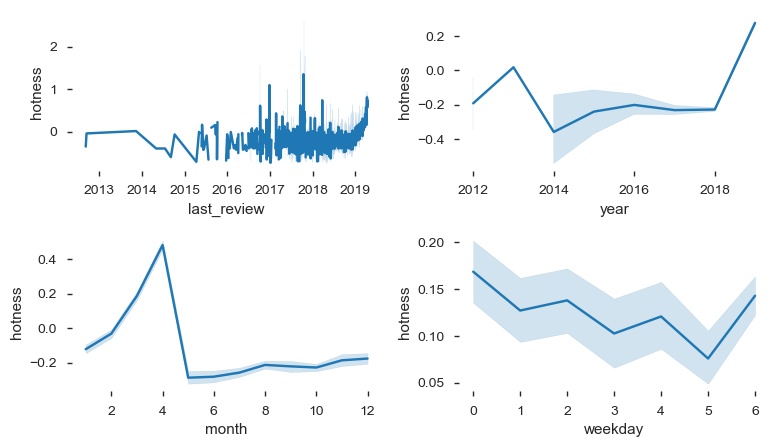

In [518]:
fig,[(ax1,ax2),(ax3,ax4)]=plt.subplots(2,2,figsize=(9,5))#绘制对称子图,子图大小
sns.lineplot(x="last_review", y="hotness",ax=ax1,
             data=newdf)
sns.lineplot(x="year", y="hotness",ax=ax2,
             data=newdf)
sns.lineplot(x="month", y="hotness",ax=ax3,
             data=newdf)
sns.lineplot(x="weekday", y="hotness",ax=ax4,
             data=newdf)
plt.subplots_adjust(wspace=0.25,hspace=0.4) #调整子图间隙

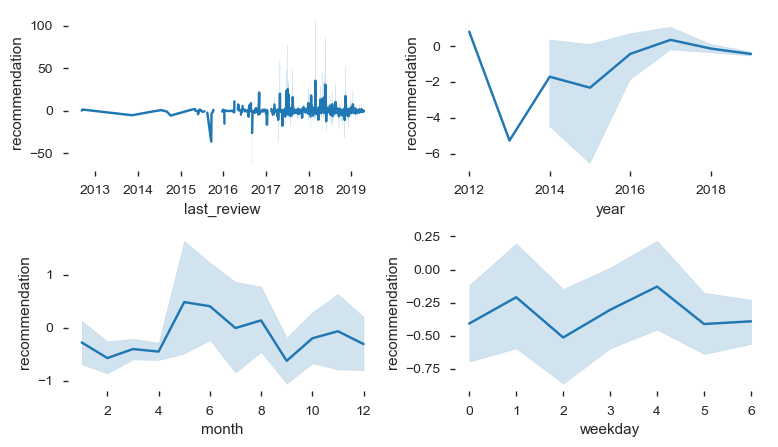

In [519]:
fig,[(ax1,ax2),(ax3,ax4)]=plt.subplots(2,2,figsize=(9,5))#绘制对称子图,子图大小
sns.lineplot(x="last_review", y="recommendation",ax=ax1,
             data=newdf)
sns.lineplot(x="year", y="recommendation",ax=ax2,
             data=newdf)
sns.lineplot(x="month", y="recommendation",ax=ax3,
             data=newdf)
sns.lineplot(x="weekday", y="recommendation",ax=ax4,
             data=newdf)
plt.subplots_adjust(wspace=0.25,hspace=0.4) #调整子图间隙

分析：短租的信息从2014年开始增长，18-19年猛增；而从月份来看3-4月份是旺季，而5月之后属于淡季;从周度来看，存在一定周末效应。

In [520]:
newdf.columns.tolist()

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'year',
 'month',
 'weekday',
 'is_workday',
 'is_holiday',
 'is_in_lieu',
 'Polarity',
 'ProbaPositive',
 'room_type__count',
 'neighbourhood__count',
 'host_id__count',
 'today',
 'last_rewtonow',
 'convenience',
 'hotness',
 'reputation',
 'experience',
 'cost_performance',
 'recommendation',
 'host_quanlity']

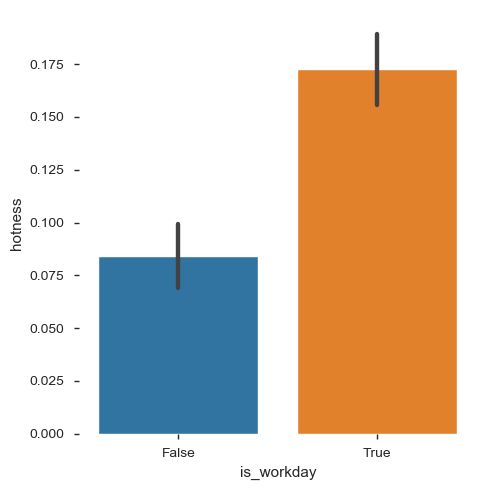

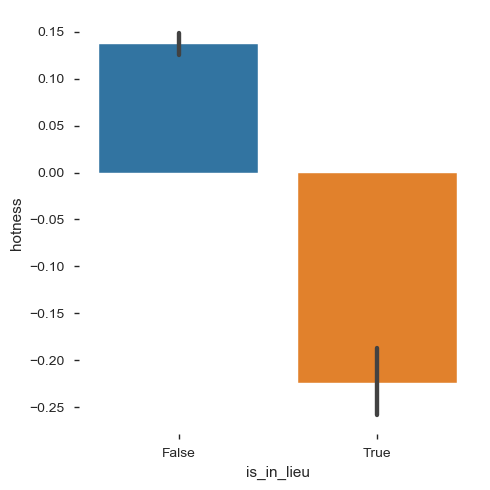

In [521]:
sns.catplot(x="is_workday", y="hotness", kind="bar", data=newdf)
sns.catplot(x="is_in_lieu", y="hotness", kind="bar", data=newdf)

评论时间一般是在工作日

### 文本可视化

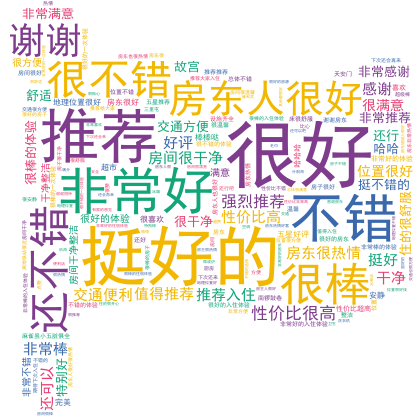

In [523]:
from stylecloud import gen_stylecloud
from IPython.display import Image# 用于在jupyter lab中显示本地图片
excludes = {"我们","特别","可以","入住","非常","真的","但是","还有","没有","问题","一个","就是"}
gen_stylecloud(file_path="Chinese_comments.csv",#绘制词云的文本
               font_path=r'C:\Windows\Fonts\simhei.ttf',#字体路径
               custom_stopwords=excludes, #停用词表
#                palette="scientific.diverging.Broc_3",# 设置配色方案
               icon_name="fas fa-flag",# 设置图标样式,使用库内自带的引用格式为："fas fa-图标标题"
               size=418,#控制输出图像文件的分辨率,默认512
               max_font_size=75,# 设置最大字体
               output_name="stylecloud.png") #输出词云文件名

Image(filename="stylecloud.png") #调用本地图片在jupyter中显示

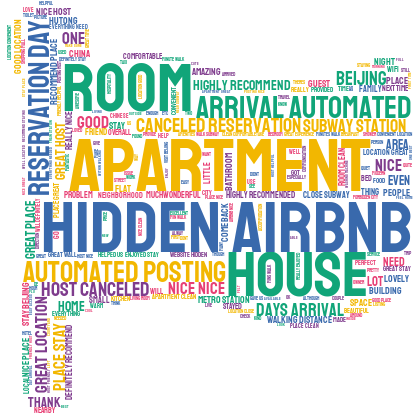

In [524]:
gen_stylecloud(file_path="English_comments.csv",#绘制词云的文本
#                font_path=r'C:\Windows\Fonts\simhei.ttf',#字体路径
#                custom_stopwords=excludes, #停用词表
#                palette="scientific.diverging.Broc_3",# 设置配色方案
               icon_name="fas fa-flag",# 设置图标样式,使用库内自带的引用格式为："fas fa-图标标题"
               size=418,#控制输出图像文件的分辨率,默认512
               max_font_size=75,# 设置最大字体
               output_name="stylecloud-E.png") #输出词云文件名

Image(filename="stylecloud-E.png") #调用本地图片在jupyter中显示

分析：正面评价很多，租客对于房源满意度较高。性价比、交通、房东性格、舒适度等比较受到重视。

## 价格影响因素分析

In [212]:
def lgb_feat_selection(df,label,k=5):
    clf = lgb.LGBMRegressor(objective='regression',metric= 'mae',silent=1,num_leaves=80,learning_rate=0.03, n_estimators=300)
    clf.fit(df.drop(label,axis=1), df[label],categorical_feature=cat_feat,verbose=0) 
    keys=df.columns
    values=clf.feature_importances_
    feim=dict(zip(keys,values))
    rank=sorted(feim.items(),  key=lambda d: d[1], reverse=True) #按得分降序
    derank=sorted(feim.items(),  key=lambda d: d[1], reverse=False) #按得分升序
    rank_keys=[i[0] for i in rank][0:k]
    derank_keys=[i[0] for i in derank][0:k]
    lgb.plot_importance(clf)
    return {"Kbest":rank_keys,"kworst":derank_keys}

In [194]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25815 entries, 0 to 25814
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              25815 non-null  int64   
 1   name                            25815 non-null  category
 2   host_id                         25815 non-null  category
 3   host_name                       25815 non-null  category
 4   neighbourhood                   25815 non-null  category
 5   latitude                        25815 non-null  float16 
 6   longitude                       25815 non-null  float16 
 7   room_type                       25815 non-null  category
 8   price                           25815 non-null  float64 
 9   minimum_nights                  25815 non-null  float64 
 10  number_of_reviews               25815 non-null  float64 
 11  last_review                     15804 non-null  category
 12  reviews_per_month 

In [197]:
cat_feat=['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood',
 'room_type',
 'is_workday',
 'is_holiday',
 'is_in_lieu']

In [206]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in cat_feat:
    newdf[i]=le.fit_transform(newdf[i])

In [210]:
newdf.drop("today",axis=1,inplace=True)

In [222]:
from feature_selector import FeatureSelector

In [223]:
fs = FeatureSelector(data =newdf.drop(indicator+["price"],axis=1), labels = newdf["price"])

In [ ]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression',  eval_metric = 'mse', 
 n_iterations = 50,  early_stopping = True)

In [232]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,latitude,485.34,0.090939,0.090939
1,host_name,468.60,0.087802,0.178741
2,name,434.96,0.081499,0.260240
3,id,428.12,0.080217,0.340457
4,longitude,398.86,0.074735,0.415192
5,host_id,393.60,0.073749,0.488941
6,reviews_per_month,355.04,0.066524,0.555466
7,ProbaPositive,337.98,0.063328,0.618793
8,availability_365,294.78,0.055233,0.674027
9,calculated_host_listings_count,229.56,0.043013,0.717040


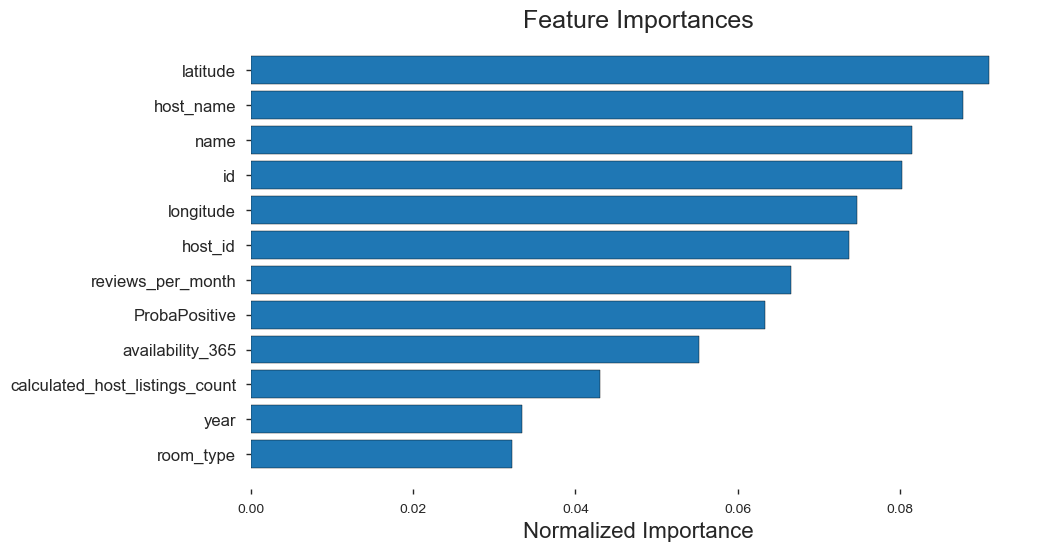

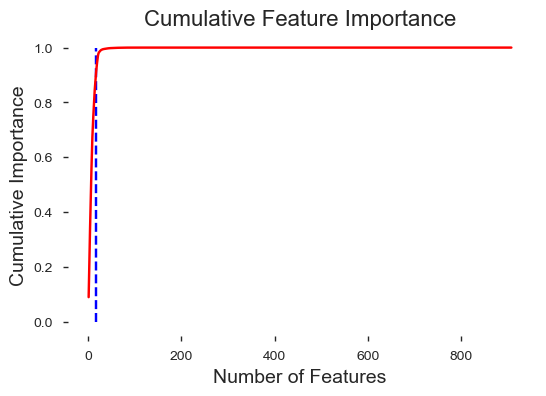

17 features required for 0.90 of cumulative importance


In [233]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.9, plot_n = 12)

In [234]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 26 original features
There are 883 one-hot features


# 总结

* 通过对房源信息进行量化，建立了'convenience','hotness', 'reputation', 'experience', 'cost_performance', 'recommendation'等指标，挖掘最受用户欢迎的房源，实现按需推荐。
* 计算房东的质量分数，实现房东的精细化运营管理。
* 时间序列分析表明：短租的信息从2014年开始增长，18-19年猛增；而从月份来看3-4月份是旺季，而5月之后属于淡季;从周度来看，存在一定周末效应。
* 短租整体正面评价很多，租客对于房源满意度较高。性价比、交通、房东性格、舒适度等比较受到重视。